# Figure 1

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, PathPatch
from matplotlib.path import Path as P
from scipy.stats import pearsonr

## Settings

In [3]:
TEXT_WIDTH = 6.7261  # in
DPI = 360

In [4]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

In [5]:
sb.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sb.set_palette('colorblind')
set_font_size(6)

## Load Data

### UMAPs

In [6]:
adatas = {
    donor: {
        model: sc.read(f'../results/fig1_{model}_{donor}_full.h5ad') 
        for model in ['moe', 'poe', 'concat', 'rna', 'tcr']
    }
    for donor in ['donor_1', 'donor_2', 'donor_3', 'donor_4', 'None', ]
}
adatas_fig = adatas['None']

In [7]:
mapper_binding = {'A1101_IVTDFSVIK_EBNA-3B_EBV_binder': 'IVTDFSVIK',
          'A0301_KLGGALQAK_IE-1_CMV_binder': 'KLGGALQAK',
          'A0201_GILGFVFTL_Flu-MP_Influenza_binder': 'GILGFVFTL',
          'A0201_ELAGIGILTV_MART-1_Cancer_binder': 'ELAGIGILTV', 
          'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder': 'AVFDRKSDAK',
          'A0201_GLCTLVAML_BMLF1_EBV_binder': 'GLCTLVAML',
          'A0301_RLRAEAQVK_EMNA-3A_EBV_binder': 'RLRAEAQVK',
          'B0801_RAKFKQLL_BZLF1_EBV_binder': 'RAKFKQLL'}

In [8]:
mapper_celltype = {
    'Tem/Trm cytotoxic T cells': 'Eff/Rest memory',
    'Tcm/Naive cytotoxic T cells': 'Naive',
    'Tem/Temra cytotoxic T cells': 'Effector memory',
    'Unknown': 'Others', 
    'MAIT cells': 'MAIT', 
    'Trm cytotoxic T cells': 'Resting memory',
    'NKT cells': 'NKT',
}

In [9]:
for adatas_tmp in adatas.values():
    for ad in adatas_tmp.values():
        ad.obs['binding_name'] = ad.obs['binding_name'].map(mapper_binding)
        ad.obs['celltype'] = ad.obs['celltype'].map(mapper_celltype)

## TCRdist

In [10]:
bindings = []
dists = []

for b, d in adatas_fig['moe'].uns['pw_tcrdist'].items():
    bindings += [b.split('_')[1]] * len(d)
    dists += d.tolist()
    
df_dists = pd.DataFrame(data={'Binder': bindings, 'TCRdist': dists})
df_dists['TCR Similarity'] = df_dists['TCRdist'].max() - df_dists['TCRdist']

# Comment out before publication
#df_dists = df_dists.sample(n=1000000)

In [11]:
x = pd.DataFrame(df_dists.groupby('Binder')['TCR Similarity'].mean())
x.index.name = None
y = pd.DataFrame(adatas_fig['moe'].obs.groupby('binding_name')['Contribution TCR'].mean())
y['binding_name'] = y.index.str.split('_').str[1]
y.index.name = None

df_contribution_dists = pd.concat([x, y], axis=1)
df_contribution_dists['binding_name'] = df_contribution_dists.index
df_contribution_dists = df_contribution_dists.rename(columns={'Contribution TCR': 'TCR-Contribution'})
df_contribution_dists

TCR Similarity  TCR-Contribution binding_name
AVFDRKSDAK      243.099801          0.509496   AVFDRKSDAK
ELAGIGILTV      302.742986          0.517691   ELAGIGILTV
GILGFVFTL       318.749562          0.553778    GILGFVFTL
GLCTLVAML       266.928773          0.547759    GLCTLVAML
IVTDFSVIK       249.937158          0.529778    IVTDFSVIK
KLGGALQAK       241.503338          0.480070    KLGGALQAK
RAKFKQLL        277.277746          0.504218     RAKFKQLL
RLRAEAQVK       238.997472          0.473449    RLRAEAQVK

## Settings

In [12]:
cp_clone = sb.color_palette('colorblind')

colors_clonotypes = ['lightgray', cp_clone[3], cp_clone[9], 
                     cp_clone[8], cp_clone[6], cp_clone[5], 
                     cp_clone[4], cp_clone[0], cp_clone[2], 
                     cp_clone[1],]

cp_bind = sb.color_palette('deep')
colors_binders = {
    'KLGGALQAK': cp_bind[8],
    'RAKFKQLL': cp_bind[2],
    'GILGFVFTL': cp_bind[1],
    'IVTDFSVIK': cp_bind[4],
    'AVFDRKSDAK': cp_bind[0],
    'GLCTLVAML': cp_bind[3],
    'RLRAEAQVK': cp_bind[9],
    'ELAGIGILTV': cp_bind[5],
    }

cp_type = sb.color_palette('tab10')
colors_celltype = {
    'Eff/Rest memory': cp_type[3],
    'Effector memory': cp_type[0],
    'Naive': cp_type[2],
    'Others': 'lightgray', # cp_type[8],
    'MAIT': cp_type[4],
    'Resting memory': cp_type[5],
    'NKT': cp_type[1],
}

color_contribution = 'coolwarm'

### Format Sankey data

In [13]:
df_sankey = adatas_fig['moe'].obs[['leiden', 'binding_name']].copy()
df_sankey = df_sankey.rename(columns={'leiden': 'leiden_moe'})
df_sankey['leiden_rna'] = adatas_fig['rna'].obs['leiden']

cp_bind = sb.color_palette('deep')
colors_binders = {
    'KLGGALQAK': cp_bind[8],
    'RAKFKQLL': cp_bind[2],
    'GILGFVFTL': cp_bind[1],
    'IVTDFSVIK': cp_bind[4],
    'AVFDRKSDAK': cp_bind[0],
    'GLCTLVAML': cp_bind[3], 
    'RLRAEAQVK': cp_bind[9],
    'ELAGIGILTV': cp_bind[5],
}
colors_moe = dict(zip(adatas_fig['moe'].obs['leiden'].value_counts().index, 
                      reversed(adatas_fig['moe'].uns['leiden_colors'])))
colors_rna = dict(zip(adatas_fig['rna'].obs['leiden'].value_counts().index, 
                      reversed(adatas_fig['rna'].uns['leiden_colors'])))

color_regplot = 'silver'

## Plotting Functions

### Umaps

In [14]:
def plot_umap(adata, grouping, ax, legend=None, ylabel=None, xlabel=None, size=0.2, bbox=1.6, cmap=None):
    xy = adata.obsm['X_umap']
    colors = adata.obs[grouping].values
    
    palette = None
    vmin, vmax = None, None
    if grouping == 'celltype':
        palette = colors_celltype
    if grouping == 'binding_name':
        palette = colors_binders
    if grouping == 'large_clonotype':
        palette = dict(zip(adata.obs['large_clonotype'].value_counts().index, colors_clonotypes))
    if grouping == 'Contribution TCR':
        palette = color_contribution
        vmin = np.percentile(adata.obs[grouping].values, 1)
        vmax = np.percentile(adata.obs[grouping].values, 99)
        colors = np.clip(colors, vmin, vmax)
    if cmap is not None:
        palette = cmap
    
    plot = sb.scatterplot(x=xy[:, 0], y=xy[:, 1], ax=ax, hue=colors, s=size, linewidth=0, 
                          palette=palette)
    
    ax.grid(False)
    sb.despine(ax=ax, left=True, bottom=True)
    ax.set_yticks([])
    ax.set_xticks([])
    
    if legend == 'Top':
        order = adata.obs[grouping].value_counts().index.tolist()
        handles, labels = ax.get_legend_handles_labels()
        labels_2_handles = dict(zip(labels, handles))
        handles = [labels_2_handles[el] for el in order]
    
        ax.legend(handles, order,markerscale=0.5, fontsize='x-small', 
                  loc='upper center', bbox_to_anchor=(1, 1.7), frameon=True, ncol=4,
                 title='Specificity', title_fontsize='small')
    elif legend is not None:
        # todo change back axis position
        order = adata.obs[grouping].value_counts().index.tolist()
        if 'Others' in order:
            order.remove('Others')
            order.append('Others')
        handles, labels = ax.get_legend_handles_labels()
        labels_2_handles = dict(zip(labels, handles))
        handles = [labels_2_handles[el] for el in order]
        
        ax.legend(handles, order, markerscale=0.5, fontsize='x-small', loc='right', bbox_to_anchor=(bbox, 0.5),
                  handletextpad=0.001, frameon=False)
    else:
        ax.legend([], [], frameon=False)
    
    if ylabel is not None:
        ax.text(0, 0.5, ylabel, size='medium', rotation=90, 
                verticalalignment='center', horizontalalignment='right', transform=ax.transAxes)
    if xlabel is not None:
        ax.text(0.5, 1., xlabel, size='medium',
                verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes)

In [15]:
def plot_colorbar(values, cmap, ax):
    vmin = np.percentile(values, 1)
    vmax = np.percentile(values, 99)
    colors = np.clip(values, vmin, vmax)
    norm = plt.Normalize(values.min(), values.max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, cax=ax)#.set_colorbar(sm)
    cbar.set_label('TCR-Contribution', rotation=90, labelpad=1)
    cbar.ax.tick_params(length=2, width=0.5)
    cbar.ax.yaxis.set_tick_params(pad=1)
    cbar.outline.set_color('black')
    cbar.outline.set_linewidth(0.5)
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')
#lot_colorbar(adatas_fig['moe'].obs['Contribution TCR'].values, 'coolwarm', ax_d_cb)

In [16]:
def plot_umap_axis(ax, offset=0):
    ax.arrow(x=0.09-offset, y=0.07-offset, dx=0, dy=0.17, color='black', width=0.001,
             head_width=0.02, head_length=0.02, clip_on=False,
             length_includes_head=True, zorder=1, transform=ax.transAxes) 
    ax.arrow(x=0.09-offset, y=0.07-offset, dx=0.16, dy=0, color='black', width=0.001, 
             head_width=0.02, head_length=0.02, clip_on=False,
             length_includes_head=True, zorder=1, transform=ax.transAxes) 
    ax.text(0.07-offset, -0.02-offset, 'UMAP1', size='x-small', transform=ax.transAxes)
    ax.text(0.01-offset, 0.07-offset, 'UMAP2', size='x-small', rotation=90, transform=ax.transAxes)

In [17]:
def plot_sankey(annotation, order_x, titles, colors, ax):
    width_element = 1 / 5
    
    left_order = annotation[order_x[0]].value_counts(normalize=True, ascending=True)
    middle_order = annotation[order_x[1]].value_counts(normalize=True, ascending=True)
    right_order = annotation[order_x[2]].value_counts(normalize=True, ascending=True)
    
    orders = [left_order, middle_order, right_order]
    
    for i, order_y in enumerate(orders):
        x = width_element * 2 * i
        y = 0
        for name, group in order_y.items():
            rect = Rectangle((x, y), width_element, group, edgecolor='white', color=colors[i][name])
            ax.add_patch(rect)
            #if i == 1 and group>0.05:
            #    ax.text(width_element*i*2+0.5*width_element, y+0.5*group, name,
            #            fontsize='x-small', color='white' if name in ['IVTDFSVIK', 'AVFDRKSDAK'] 
            #            else 'black',
            #           horizontalalignment='center', verticalalignment='center',)
            
            y = y + group
        label = ax.text(width_element*i*2+0.5*width_element, 1.02, titles[i],
                       horizontalalignment='center',)
            
    
    for i in range(2):
        df_flows = annotation.groupby(order_x[i])[order_x[i+1]].value_counts(ascending=True).unstack(fill_value=0)
        df_flows = pd.DataFrame(data=df_flows.values / df_flows.values.sum(), 
                                index=df_flows.index, 
                                columns=df_flows.columns)

        x0 = width_element*2*i+width_element
        x1 = x0 + width_element * 9 / 20
        x2 = x0 + width_element * 11 / 20
        x3 = width_element*(i+1)*2

        center_offset = {}
        y_right = 0
        for name, height in orders[i+1].items():
            y_right += height
            center_offset[name] = y_right
        #print(center_offset)
        
        y = 1
        for group_left in reversed(orders[i].index):
            for group_right in reversed(orders[i+1].index):
                height = df_flows.loc[group_left][group_right]
                if height == 0:
                    continue
                y_center = center_offset[group_right]
                path_data = [
                    (P.MOVETO, (x0, y)),
                    (P.LINETO, (x0, y - height)),
                    (P.CURVE4, (x1, y - height)),
                    (P.CURVE4, (x2, y_center - height)), #-right_y - flow)),
                    (P.CURVE4, (x3, y_center - height)), #-right_y - flow)),
                    (P.LINETO, (x3, y_center)), #-right_y)),
                    (P.CURVE4, (x2, y_center)), #-right_y)),
                    (P.CURVE4, (x1, y)),
                    (P.CURVE4, (x0, y)),
                    (P.CLOSEPOLY, (x0, y)),
                ]
                codes, verts = zip(*path_data)
                path = P(verts, codes)
                patch = PathPatch(
                    path,
                    alpha=0.3,
                    edgecolor='white',
                    color=colors[1][group_right if i==0 else group_left],
                    zorder=-5
                )
                if height > 0.0075:
                    ax.add_patch(patch)  
                y -= height   
                center_offset[group_right] -= height
    ax.axis('off')
    sb.despine(ax=ax, left=True, bottom=True)

In [18]:
def plot_tcrdist(data, col_values, groups, ax):
    # data = data.sample(n=1000000)
    plot = sb.violinplot(data=data, x=groups, y=col_values, scale='width', 
                      palette=colors_binders, ax=ax, linewidth=0.75,
                      order=colors_binders.keys())
    
    ax.grid(False)
    sb.despine(ax=ax)
    
    ax.set_ylabel('TCR Similarity', labelpad=1)
    ax.set_xticklabels([])
    ax.set_xlabel('Specificity', labelpad=-5)
    ax.tick_params('y', pad=-3)

In [19]:
def plot_contribution(data, col_values, groups, ax):
    plot = sb.violinplot(data=data, x=groups, y=col_values, linewidth=0.75, scale='width', 
                      palette=colors_binders, showfliers=False, ax=ax,
                      order=colors_binders.keys())
    
    ax.grid(False)
    sb.despine(ax=ax)
    
    ax.set_ylabel('TCR-Contribution', labelpad=1)
    ax.set_xticklabels([])
    ax.set_xlabel('Specificity', labelpad=-5)
    ax.tick_params('y', pad=-3)

In [20]:
def plot_scatter(data, x, y, ax):
    corr_test = pearsonr(data[x].values, data[y].values)
    corr_test = pearsonr(data[x].values, data[y].values)
    plot = sb.regplot(data=data, x=x, y=y, scatter=False, ax=ax, 
                      line_kws={'zorder': -1, 'linewidth': 1, 'color': color_regplot})
    sb.scatterplot(data=data, x=x, y=y, hue='binding_name', ax=ax, size=1.5, zorder=1, palette=colors_binders)

    print(corr_test)
    plot.set_title(f'Pearson: {corr_test[0]:.2f}', pad=0)
    
    ax.grid(False)
    sb.despine(ax=ax)
    
    ax.set_ylabel(ax.get_ylabel(), labelpad=0)
    ax.legend().remove()#(title=None, handletextpad=0.)
    ax.tick_params('y', pad=-3)

In [21]:
def plot_empty(ax):
    ax.axis('off')

## Figure 1

C:\Users\felix.drost\Anaconda3\envs\mvTCR\lib\site-packages\seaborn\relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)
C:\Users\felix.drost\Anaconda3\envs\mvTCR\lib\site-packages\seaborn\relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)
C:\Users\felix.drost\Anaconda3\envs\mvTCR\lib\site-packages\seaborn\relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested seque

(0.641228336291769, 0.08661401180114509)


C:\Users\FELIX~1.DRO\AppData\Local\Temp/ipykernel_27652/3168614981.py:173: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


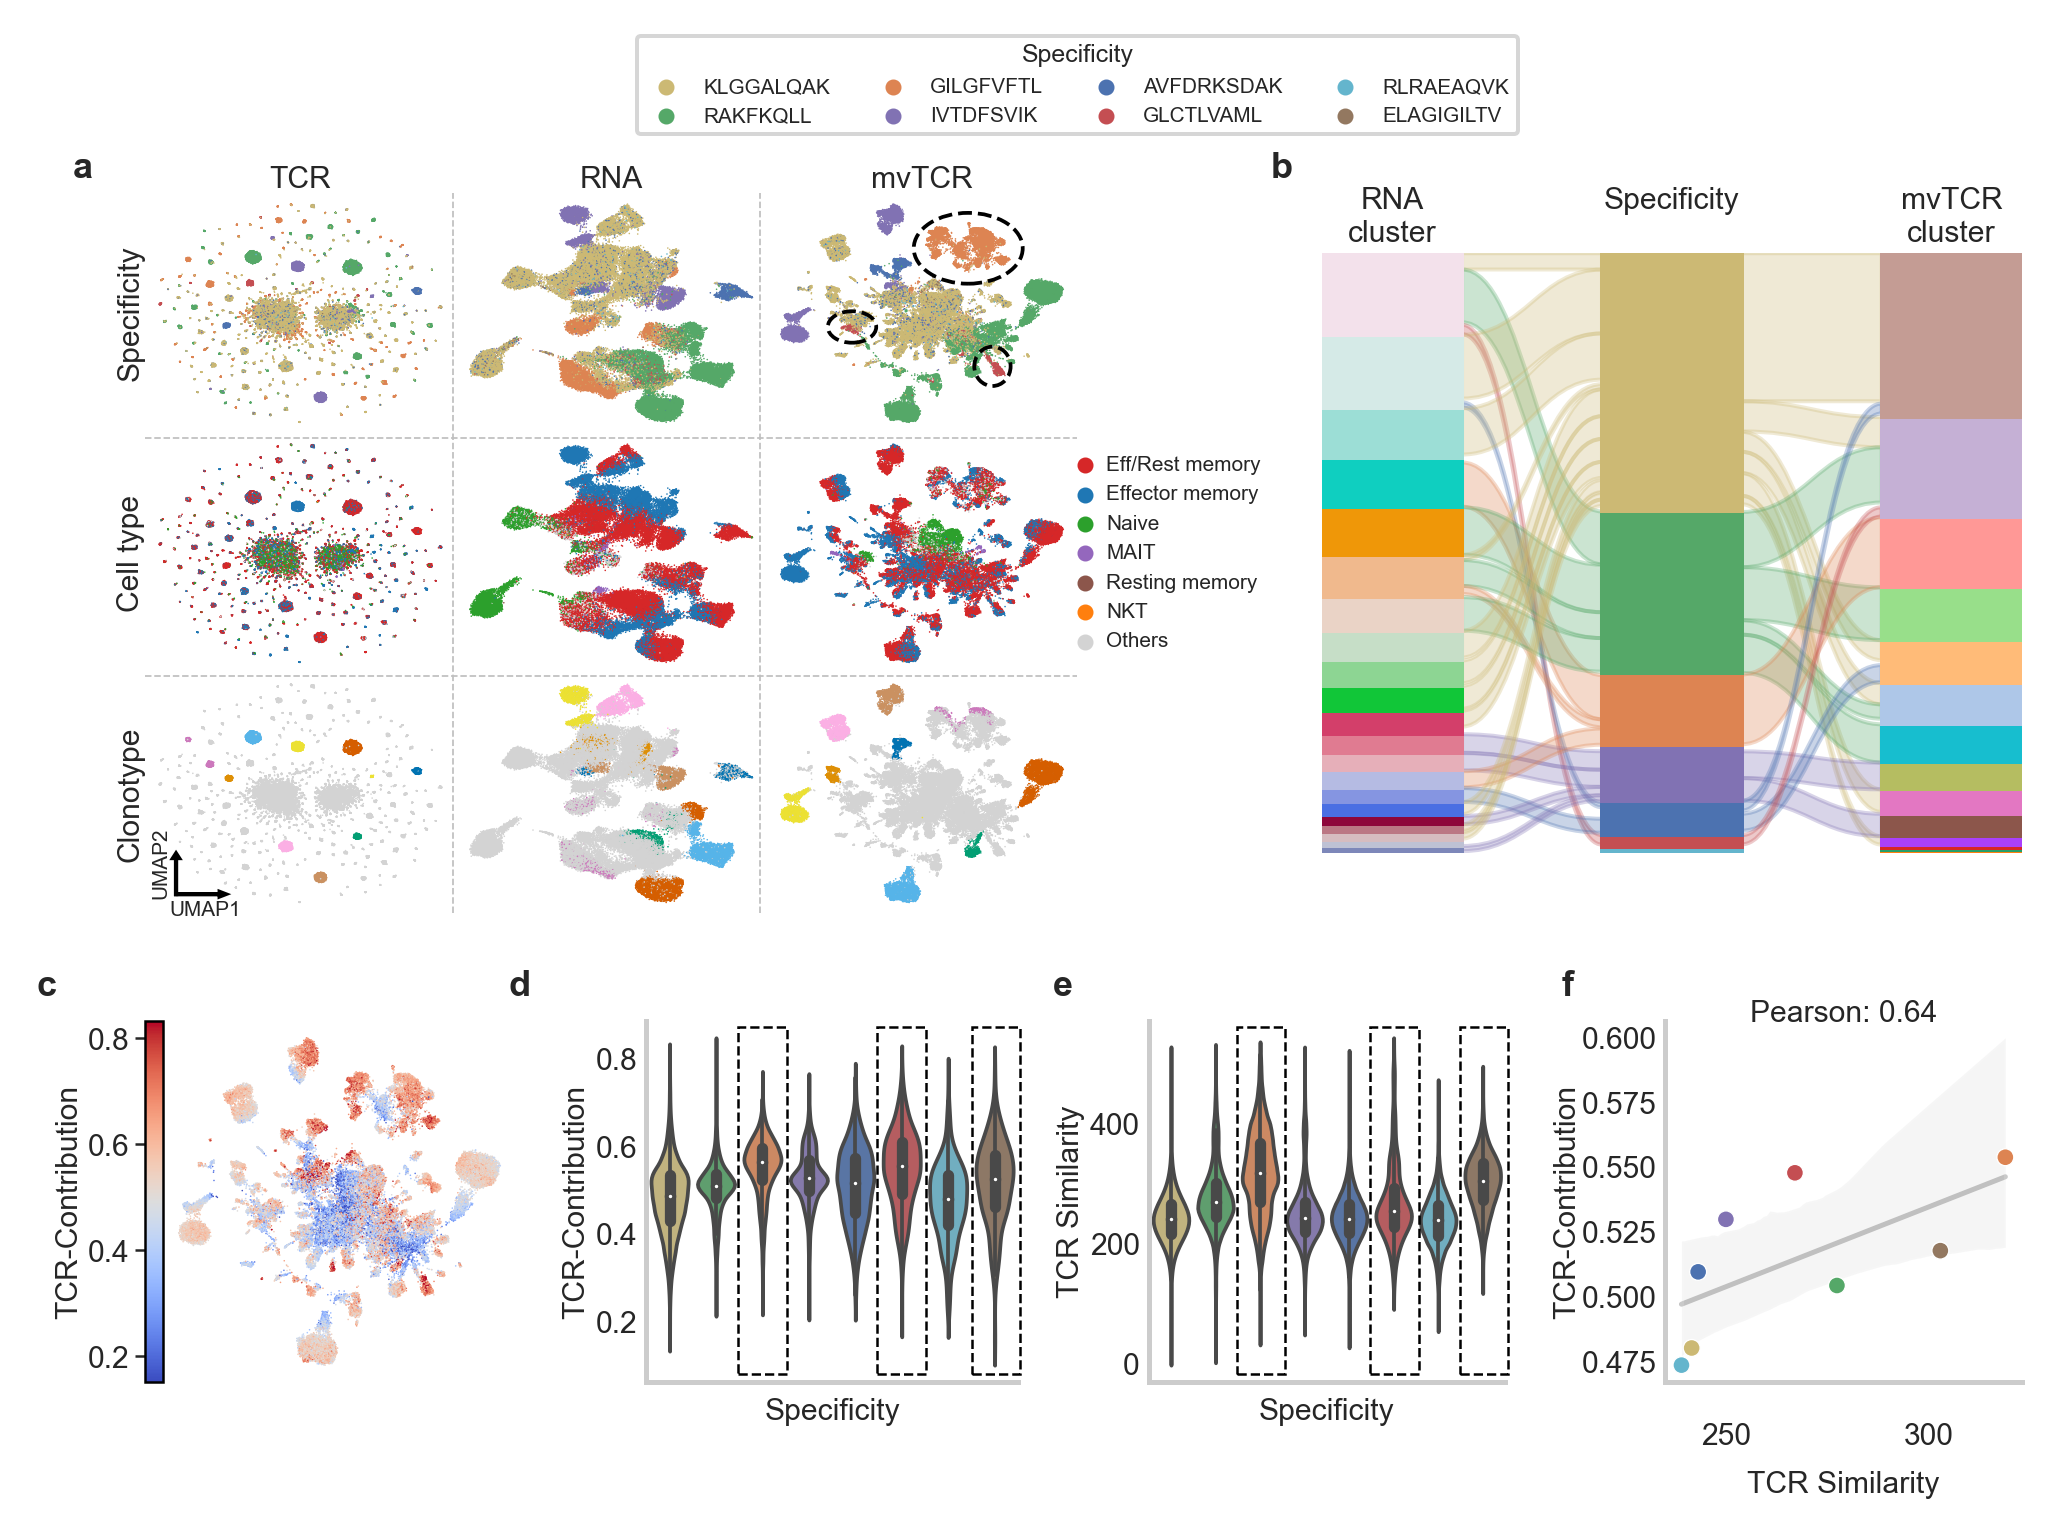

In [22]:
fig = plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.65),
                 dpi=DPI)
gridspecs = {}

#a    bbb c
#     bbb c
#     bbb c
#c  d  e

# a=Sketch, b=UMAPs, c=10x, d=Covid, e=Tessa


gridspecs["gs_a-e"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    height_ratios=[4, 2],
    width_ratios=[1],
    hspace=0.2,
)

gridspecs["gs_ab"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_a-e"][0],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[4, 3],
    wspace=0.3,
)

gridspecs["gs_a"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_ab"][0],
    nrows=3,
    ncols=3,
    height_ratios=[1, 1, 1],
    width_ratios=[1, 1, 1],
    wspace=0.,
    hspace=0.,
)

gridspecs["gs_b"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_ab"][1],
    nrows=3,
    ncols=1,
    height_ratios=[0.1, 1, 0.1],
    width_ratios=[1],
    wspace=0.,
    hspace=0.,
)

gridspecs["gs_c-f"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_a-e"][1],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.15,
)

gridspecs["gs_cd"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_c-f"][0],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.35,
)

gridspecs["gs_d"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_cd"][0],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[0.05, 1],
    wspace=0.0,
)

gridspecs["gs_ef"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_c-f"][1],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.45,
)

ax_a = {}
for i in range(9):
    ax_a[i] = fig.add_subplot(gridspecs["gs_a"][i])

ax_b = fig.add_subplot(gridspecs["gs_b"][1])

ax_c = fig.add_subplot(gridspecs["gs_ef"][0])
ax_d = fig.add_subplot(gridspecs["gs_d"][1])
ax_d_cb = fig.add_subplot(gridspecs["gs_d"][0])

ax_e = fig.add_subplot(gridspecs["gs_cd"][1])
ax_f = fig.add_subplot(gridspecs["gs_ef"][1])

plot_umap(adatas_fig['tcr'], 'binding_name', ax_a[0], xlabel='TCR', size=0.1, ylabel='Specificity')
plot_umap(adatas_fig['rna'], 'binding_name', ax_a[1], xlabel='RNA', size=0.1)
plot_umap(adatas_fig['moe'], 'binding_name', ax_a[2], xlabel='mvTCR', size=0.1, legend='Top', bbox=1.65)

plot_umap(adatas_fig['tcr'], 'celltype', ax_a[3], size=0.1, ylabel='Cell type',)
plot_umap(adatas_fig['rna'], 'celltype', ax_a[4], size=0.1)
plot_umap(adatas_fig['moe'], 'celltype', ax_a[5], size=0.1, legend=True, bbox=1.65)

plot_umap(adatas_fig['tcr'], 'large_clonotype', ax_a[6], size=0.1, ylabel='Clonotype',)
plot_umap(adatas_fig['rna'], 'large_clonotype', ax_a[7], size=0.1)
plot_umap(adatas_fig['moe'], 'large_clonotype', ax_a[8], size=0.1)

plot_umap_axis(ax_a[6], offset=-0.01)

ax_a_full =  fig.add_subplot(gridspecs["gs_a"][:, :], sharex=ax_a[4])
# set background color to transparent and turn off the frame
ax_a_full.patch.set_alpha(0)
ax_a_full.axis("off")
# plot the vertical line
ax_a_full.plot([0.33, 0.33], [0, 1], c='silver', linestyle='dashed', linewidth=0.35, transform=ax_a_full.transAxes)
ax_a_full.plot([0.66, 0.66], [0, 1], c='silver', linestyle='dashed', linewidth=0.35, transform=ax_a_full.transAxes)

ax_a_full.plot([0, 1], [0.33, 0.33], c='silver', linestyle='dashed', linewidth=0.35, transform=ax_a_full.transAxes)
ax_a_full.plot([0, 1], [0.66, 0.66], c='silver', linestyle='dashed', linewidth=0.35, transform=ax_a_full.transAxes)

plot_sankey(df_sankey, ['leiden_rna', 'binding_name', 'leiden_moe'], 
            ['RNA\ncluster', 'Specificity\n', 'mvTCR\ncluster'], 
            [colors_rna, colors_binders, colors_moe],
            ax_b)

plot_tcrdist(df_dists, 'TCR Similarity', 'Binder', ax_c)

plot_umap(adatas_fig['moe'], 'Contribution TCR', ax_d, size=0.1)
plot_colorbar(adatas_fig['moe'].obs['Contribution TCR'].values, color_contribution, ax_d_cb)

plot_contribution(adatas_fig['moe'].obs, 'Contribution TCR', 'binding_name', ax_e)
plot_scatter(df_contribution_dists, 'TCR Similarity', 'TCR-Contribution', ax_f)


fig.text(0.095, 0.89, 'a', size='large', weight='bold')
fig.text(0.59, 0.89, 'b', size='large', weight='bold')

fig.text(0.08, 0.37, 'c', size='large', weight='bold')
fig.text(0.275, 0.37, 'd', size='large', weight='bold')
fig.text(0.5, 0.37, 'e', size='large', weight='bold')
fig.text(0.71, 0.37, 'f', size='large', weight='bold')

from matplotlib.patches import Ellipse, Rectangle
el_gil = Ellipse(xy=(0.465, 0.845), width=0.045, height=0.045, edgecolor='black', #colors_binders['GILGFVFTL'],
                 fc='None', lw=0.75, linestyle='--', transform=fig.transFigure, figure=fig)
el_glc1 = Ellipse(xy=(0.417, 0.795), width=0.02, height=0.02, edgecolor='black', #colors_binders['GLCTLVAML'],
                 fc='None', lw=0.75, linestyle='--', transform=fig.transFigure, figure=fig)
el_glc2 = Ellipse(xy=(0.475, 0.77), width=0.015, height=0.025, edgecolor='black', #colors_binders['GLCTLVAML'],
                 fc='None', lw=0.75, linestyle='--', transform=fig.transFigure, figure=fig)


bx_gil1 = Rectangle(xy=(0.37, 0.13), width=0.02, height=0.22, edgecolor='black', #colors_binders['GILGFVFTL'],
                 fc='None', lw=0.5, linestyle='--', transform=fig.transFigure, figure=fig)
bx_gil2 = Rectangle(xy=(0.576, 0.13), width=0.02, height=0.22, edgecolor='black', #colors_binders['GILGFVFTL'],
                 fc='None', lw=0.5, linestyle='--', transform=fig.transFigure, figure=fig)

bx_glc1 = Rectangle(xy=(0.4275, 0.13), width=0.02, height=0.22, edgecolor='black', #colors_binders['GLCTLVAML'],
                 fc='None', lw=0.5, linestyle='--', transform=fig.transFigure, figure=fig)
bx_glc2 = Rectangle(xy=(0.631, 0.13), width=0.02, height=0.22, edgecolor='black', #colors_binders['GLCTLVAML'],
                 fc='None', lw=0.5, linestyle='--', transform=fig.transFigure, figure=fig)

bx_ela1 = Rectangle(xy=(0.4665, 0.13), width=0.02, height=0.22, edgecolor='black', #colors_binders['ELAGIGILTV'],
                 fc='None', lw=0.5, linestyle='--', transform=fig.transFigure, figure=fig)
bx_ela2 = Rectangle(xy=(0.668, 0.13), width=0.02, height=0.22, edgecolor='black', #colors_binders['ELAGIGILTV'],
                 fc='None', lw=0.5, linestyle='--', transform=fig.transFigure, figure=fig)

fig.patches.extend([el_gil, el_glc1, el_glc2, bx_gil1, bx_gil2, bx_glc1, bx_glc2, bx_ela1, bx_ela2,])

fig.tight_layout()
fig.savefig('../figures/fig_umap10x.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/fig_umap10x.png',
           dpi=DPI, bbox_inches='tight')

In [23]:
print(f'Amount of cells: {len(adatas_fig["moe"])}')

Amount of cells: 61237


In [24]:
print('Amount of clusters')
for mod in ['tcr', 'rna', 'moe']:
    print(f'{mod} - {adatas_fig[mod].obs["leiden"].nunique()}')

Amount of clusters
tcr - 214
rna - 22
moe - 15


In [25]:
adatas_fig['moe'][adatas_fig['moe'].obs['binding_name'].str.startswith('GIL')
                 ].obs.groupby('binding_name')['leiden'].value_counts(normalize=True)

binding_name  leiden
GILGFVFTL     2         0.964905
              1         0.015989
              4         0.011653
              0         0.004878
              5         0.001762
              3         0.000542
              8         0.000136
              12        0.000136
Name: leiden, dtype: float64

In [26]:
adatas_fig['moe'][adatas_fig['moe'].obs['leiden']=='2'
                 ].obs['binding_name'].value_counts(normalize=True)

GILGFVFTL     0.991507
KLGGALQAK     0.005848
AVFDRKSDAK    0.001392
RAKFKQLL      0.000696
IVTDFSVIK     0.000418
GLCTLVAML     0.000139
Name: binding_name, dtype: float64

In [27]:
adatas_fig['rna'][adatas_fig['rna'].obs['binding_name'].str.startswith('GIL')
                 ].obs.groupby('binding_name')['leiden'].value_counts(normalize=True)

binding_name  leiden
GILGFVFTL     3         0.610705
              13        0.223577
              5         0.110027
              1         0.023306
              10        0.016396
              0         0.006098
              17        0.002575
              19        0.002168
              15        0.002033
              7         0.001084
              8         0.000542
              2         0.000407
              4         0.000407
              18        0.000271
              6         0.000136
              9         0.000136
              21        0.000136
Name: leiden, dtype: float64

In [28]:
adatas_fig['moe'][adatas_fig['moe'].obs['binding_name'].str.startswith('IVT')
                 ].obs.groupby('binding_name')['leiden'].value_counts(normalize=True)

binding_name  leiden
IVTDFSVIK     7         0.481527
              9         0.404278
              4         0.067350
              0         0.025986
              1         0.010783
              5         0.004066
              8         0.003005
              10        0.000707
              2         0.000530
              3         0.000530
              6         0.000530
              12        0.000354
              14        0.000354
Name: leiden, dtype: float64

In [29]:
adatas_fig['rna'][adatas_fig['rna'].obs['binding_name'].str.startswith('IVT')
                 ].obs.groupby('binding_name')['leiden'].value_counts(normalize=True)

binding_name  leiden
IVTDFSVIK     11        0.333746
              12        0.308998
              16        0.148135
              20        0.092629
              10        0.042956
              1         0.034471
              2         0.007955
              0         0.007071
              7         0.003889
              9         0.003535
              19        0.003535
              8         0.002828
              5         0.002298
              13        0.001591
              17        0.001591
              18        0.001237
              6         0.000884
              14        0.000707
              21        0.000707
              3         0.000530
              15        0.000530
              4         0.000177
Name: leiden, dtype: float64

In [30]:
adatas_fig['moe'][adatas_fig['moe'].obs['binding_name'].str.startswith('ELA')
                 ].obs.groupby('binding_name')['leiden'].value_counts(normalize=True)

binding_name  leiden
ELAGIGILTV    0         0.867220
              4         0.074689
              5         0.049793
              1         0.008299
Name: leiden, dtype: float64

In [31]:
adatas_fig['rna'][adatas_fig['rna'].obs['binding_name'].str.startswith('ELA')
                 ].obs.groupby('binding_name')['leiden'].value_counts(normalize=True)

binding_name  leiden
ELAGIGILTV    19        0.585062
              7         0.170124
              8         0.082988
              1         0.074689
              18        0.049793
              10        0.033195
              0         0.004149
Name: leiden, dtype: float64

In [32]:
adatas_fig['moe'].obs.groupby('binding_name')['Contribution TCR'].mean().sort_values(ascending=False)

binding_name
GILGFVFTL     0.553778
GLCTLVAML     0.547759
IVTDFSVIK     0.529778
ELAGIGILTV    0.517691
AVFDRKSDAK    0.509496
RAKFKQLL      0.504218
KLGGALQAK     0.480070
RLRAEAQVK     0.473449
Name: Contribution TCR, dtype: float64

In [33]:
df_dists.groupby(['Binder'])['TCR Similarity'].mean().sort_values(ascending=False)

Binder
GILGFVFTL     318.749562
ELAGIGILTV    302.742986
RAKFKQLL      277.277746
GLCTLVAML     266.928773
IVTDFSVIK     249.937158
AVFDRKSDAK    243.099801
KLGGALQAK     241.503338
RLRAEAQVK     238.997472
Name: TCR Similarity, dtype: float64

In [34]:
df_dists['TCR Similarity'].mean()

242.3745626160282

In [35]:
adatas_fig['moe'].obs.groupby('donor')['binding_name'].value_counts(normalize=True)

donor    binding_name
donor_1  KLGGALQAK       0.287789
         IVTDFSVIK       0.280112
         GILGFVFTL       0.203133
         AVFDRKSDAK      0.191825
         ELAGIGILTV      0.017844
         RLRAEAQVK       0.010478
         RAKFKQLL        0.006847
         GLCTLVAML       0.001971
donor_2  RAKFKQLL        0.603953
         GILGFVFTL       0.199183
         KLGGALQAK       0.132016
         GLCTLVAML       0.045048
         AVFDRKSDAK      0.013323
         IVTDFSVIK       0.002944
         RLRAEAQVK       0.002503
         ELAGIGILTV      0.001031
donor_3  KLGGALQAK       0.925491
         AVFDRKSDAK      0.057318
         RLRAEAQVK       0.009513
         IVTDFSVIK       0.005795
         ELAGIGILTV      0.001352
         GILGFVFTL       0.000435
         RAKFKQLL        0.000097
donor_4  IVTDFSVIK       0.741528
         KLGGALQAK       0.220549
         AVFDRKSDAK      0.030124
         RLRAEAQVK       0.003765
         ELAGIGILTV      0.003497
         GILGFVFTL       0

In [36]:
adatas_fig['moe']

AnnData object with n_obs × n_vars = 61237 × 40
    obs: 'batch', 'donor', 'binding_name', 'clonotype', 'large_clonotype', 'celltype', 'Contribution TCR', 'leiden'
    uns: 'binding_name_colors', 'leiden', 'leiden_colors', 'neighbors', 'pw_tcrdist', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

## Supplementary Figure 1

In [37]:
donor_mapper = {
    'donor_1': 'Donor 1',
    'donor_2': 'Donor 2',
    'donor_3': 'Donor 3',
    'donor_4': 'Donor 4',
    'None': 'Pooled',
}

model_mapper = {
    'moe': 'mvTCR',
    'poe': 'PoE',
    'concat': 'Concat',
    'rna': 'RNA',
    'tcr': 'TCR',
}

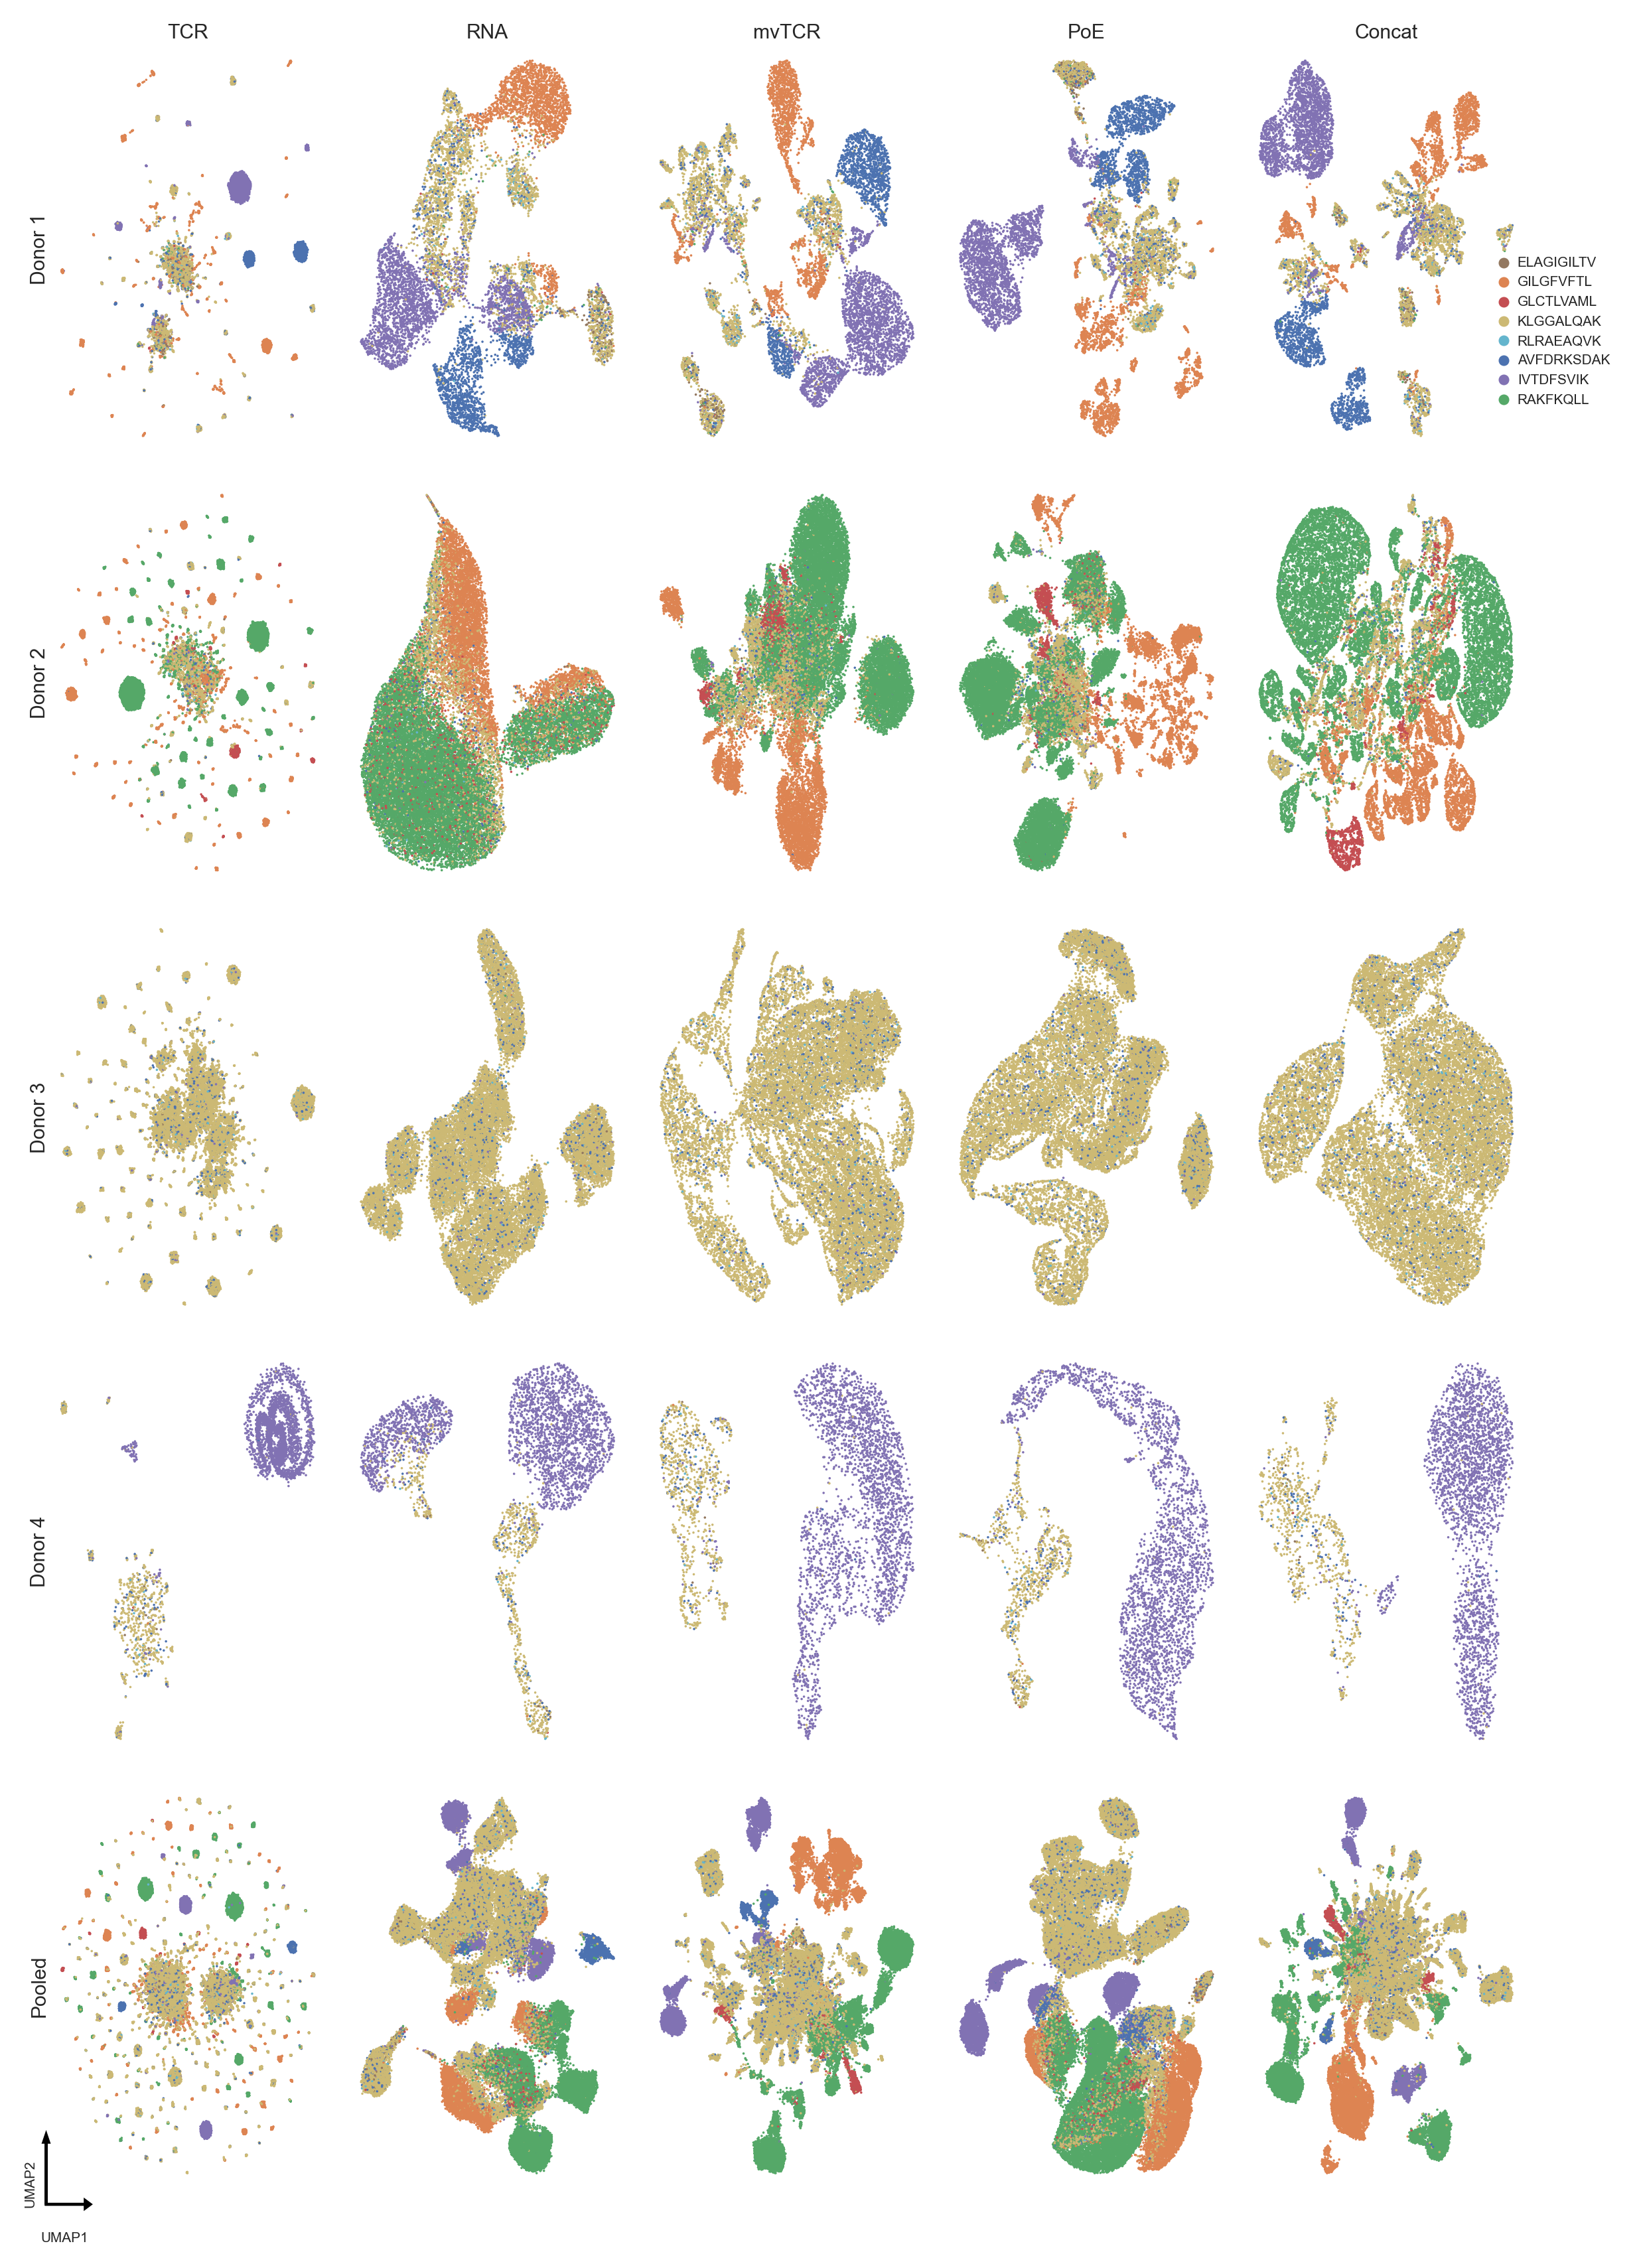

In [38]:
fig = plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH * 1.4),
                 dpi=DPI)
gridspecs = {}

# bbbbb
# bbbbb
# bbbbb
#  cdf

# b=UMAPs, c=10x, e=Tessa

gridspecs["gs_a"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=5,
    ncols=5,
    height_ratios=[1, 1, 1, 1, 1],
    width_ratios=[1, 1, 1, 1, 1],
)

i = 0
axes = {}
for donor, model_dict in adatas.items():
    for model in ['tcr', 'rna', 'moe', 'poe', 'concat']:
        adata_tmp = model_dict[model]
        ax = fig.add_subplot(gridspecs["gs_a"][i])
        axes[i] = ax
    
        ylabel = donor_mapper[donor] if i%5==0 else None
        xlabel = model_mapper[model] if i<5 else None
        
        plot_umap(adata_tmp, 'binding_name', ax, ylabel=ylabel, xlabel=xlabel, legend=False, size=0.5, bbox=1.3)
        ax.legend().remove()
        i += 1
        
axes[4].legend(*axes[i-1].get_legend_handles_labels(), 
               markerscale=0.5, fontsize='x-small', handletextpad=0.0,
               loc='center right', bbox_to_anchor=(1.35, 0.3), frameon=False, ncol=1)
plot_umap_axis(axes[20], offset=0.1)    

fig.tight_layout()
fig.savefig('../figures/suppl_umap10x.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/suppl_umap10x.png',
           dpi=DPI, bbox_inches='tight')

## Suppl. 2

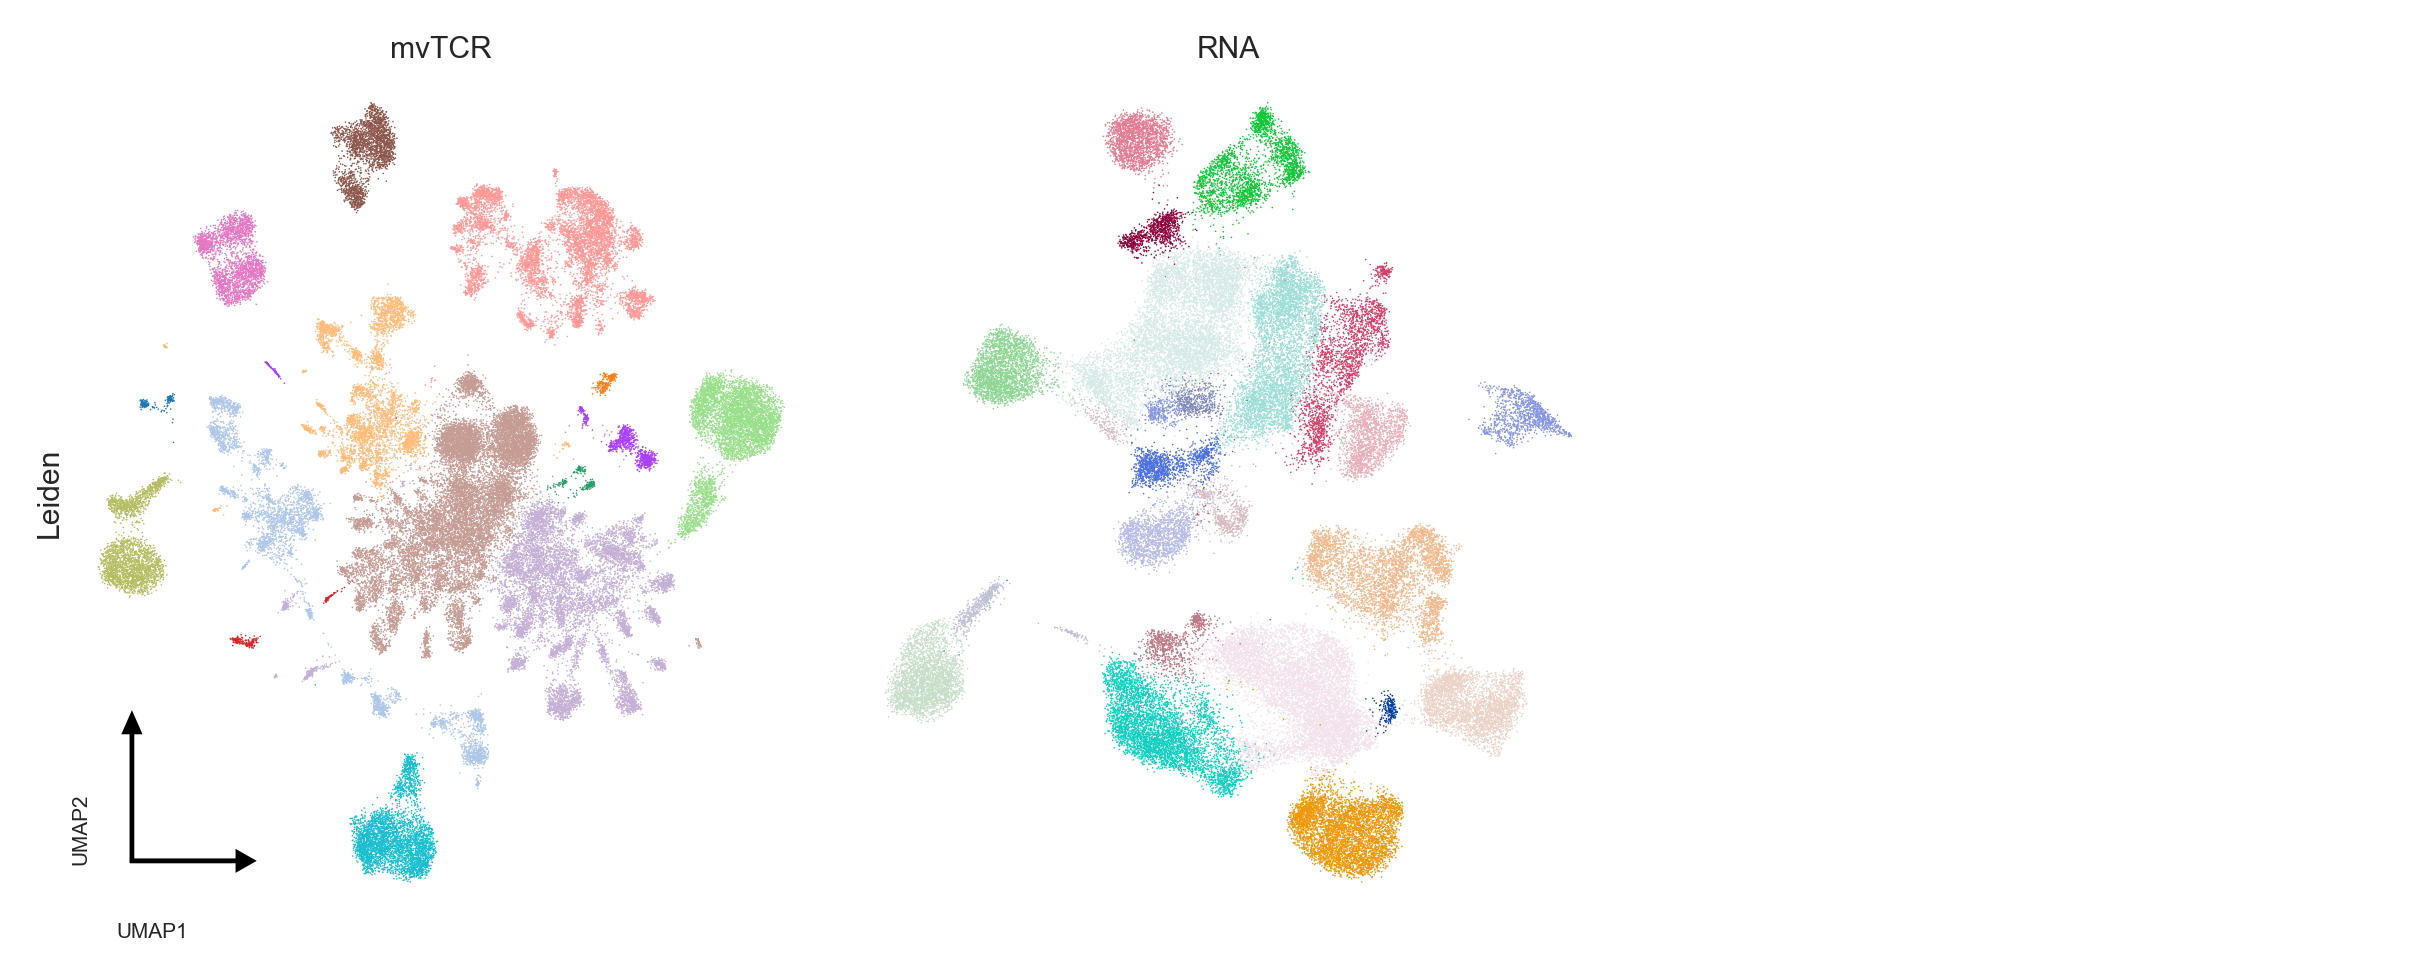

In [39]:
fig = plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.4),
                 dpi=DPI)
gridspecs = {}

gridspecs["gs_a"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=3,
    height_ratios=[1],
    width_ratios=[1, 1,1],
)


ax_mvtcr = fig.add_subplot(gridspecs["gs_a"][0])
ax_rna = fig.add_subplot(gridspecs["gs_a"][1])
ax_empty = fig.add_subplot(gridspecs["gs_a"][2])  
    
plot_umap(adatas_fig['moe'], 'leiden', ax_mvtcr, size=0.1, ylabel='Leiden', xlabel='mvTCR', cmap=colors_moe)
plot_umap(adatas_fig['rna'], 'leiden', ax_rna, size=0.1, xlabel='RNA', cmap=colors_rna)
plot_empty(ax_empty)

plot_umap_axis(ax_mvtcr, offset=0.)  


fig.tight_layout()
fig.savefig('../figures/suppl_10xclustering.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/suppl_10xclustering.png',
           dpi=DPI, bbox_inches='tight')